# Timing Redis Operations

*Data Structures and Information Retrieval in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/DSIRP/blob/main/chapters/time_redis.ipynb)

## Performance of lpush and rpush

The [Redis documentation](https://redis.io/topics/data-types) says

> The main features of Redis Lists from the point of view of time complexity are the support for constant time insertion and deletion of elements near the head and tail, even with many millions of inserted items. Accessing elements is very fast near the extremes of the list but is slow if you try accessing the middle of a very big list, as it is an O(N) operation.

In class recently, we saw some behavior that suggested that `lpush` might be linear (as we would expect from an array list, like Python lists) rather than constant time (as we would expect from a linked list).

So let's find out.

In [2]:
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install redis-server
    !/usr/local/lib/python*/dist-packages/redis_server/bin/redis-server --daemonize yes
else:
    !redis-server --daemonize yes

76405:C 03 Nov 2021 09:46:34.160 # oO0OoO0OoO0Oo Redis is starting oO0OoO0OoO0Oo
76405:C 03 Nov 2021 09:46:34.160 # Redis version=5.0.3, bits=64, commit=00000000, modified=0, pid=76405, just started
76405:C 03 Nov 2021 09:46:34.160 # Configuration loaded


In [3]:
try:
    import redis
except ImportError:
    !pip install redis

In [4]:
import redis

r = redis.Redis()

In [8]:
import os

def etime():
    """Measures user and system time this process has used.

    Returns the sum of user and system time."""
    user, sys, chuser, chsys, real = os.times()
    return user+sys

In [9]:
def time_func(func, n):
    """Run a function and return the elapsed time.

    func: function
    n: problem size, passed as an argument to func

    returns: user+sys time in seconds
    """
    start = etime()
    func(n)
    end = etime()
    elapsed = end - start
    return elapsed

In [15]:
def run_timing_test(func, max_time=1):
    """Tests the given function with a range of values for n.

    func: function object

    returns: list of ns and a list of run times.
    """
    ns = []
    ts = []
    for i in range(10, 28):
        n = 2**i
        t = time_func(func, n)
        print(n, t)
        if t > 0:
            ns.append(n)
            ts.append(t)
        if t > max_time:
            break

    return ns, ts

## lpush


In [22]:
def lpush(n):
    key = 'lpush_test'
    [r.lpush(key, x) for x in range(n)]
    r.delete(key)

In [23]:
def rpush(n):
    key = 'rpush_test'
    [r.rpush(key, x) for x in range(n)]
    r.delete(key)

In [24]:
ns, ts = run_timing_test(rpush)

1024 0.03999999999999915
2048 0.09000000000000163
4096 0.14000000000000057
8192 0.29999999999999893
16384 0.5999999999999996
32768 1.1799999999999997


In [25]:
def fit(ns, ts, exp=1.0, index=-1):
    """Fits a curve with the given exponent.

    ns: sequence of problem sizes
    ts: sequence of times
    exp: exponent of the fitted curve
    index: index of the element the fitted line should go through

    returns: sequence of fitted times


    """
    # Use the element with the given index as a reference point,
    # and scale all other points accordingly.
    nref = ns[index]
    tref = ts[index]

    tfit = []
    for n in ns:
        ratio = n / nref
        t = ratio**exp * tref
        tfit.append(t)

    return tfit

In [26]:
def plot_timing_test(ns, ts, label='', color='C0', exp=1.0, scale='log'):
    """Plots data and a fitted curve.

    ns: sequence of n (problem size)
    ts: sequence of t (run time)
    label: string label for the data curve
    color: string color for the data curve
    exp: exponent (slope) for the fitted curve
    scale: string passed to xscale and yscale
    """
    ts_fit = fit(ns, ts, exp)
    fit_label = 'exp = %d' % exp
    plt.plot(ns, ts_fit, label=fit_label, color='0.7', linestyle='dashed')
    plt.plot(ns, ts, 'o-', label=label, color=color, alpha=0.7)
    plt.xlabel('Problem size (n)')
    plt.ylabel('Runtime (seconds)')
    plt.xscale(scale)
    plt.yscale(scale)
    plt.legend()

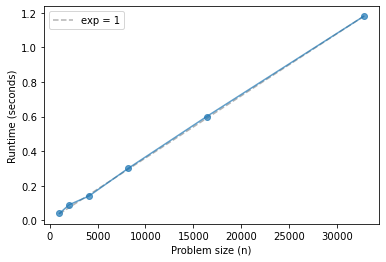

In [28]:
plot_timing_test(ns, ts, scale='linear')